In [50]:
SOURCE_MARKDOWN = """
**Subject: The Wordpress vs WP Engine Drama**

In a surprising twist of events, the open-source giant WordPress is entangled in a dramatic controversy surrounding its licensing policies aimed squarely at WP Engine, stirring fierce discussions across the web. **"How can you expect any goodwill towards open-source from a community when you insist on enforcing fees?"** This quote captures the mounting frustration many in the tech community feel as these events unfold.

**Background Context**  
WordPress, an open-source content management system, has thrived on its community-driven model for years. However, recently, the organization faced backlash due to new licensing fee structures selectively impacting WP Engine, a leading managed Wordpress host. This move has raised concerns among other hosting companies and developers about potential instability and implications for open-source projects.

---

**The Emergence of Tension**  
The friction began to surface as Automattic, the parent company of WordPress, targeted WP Engine for allegedly not contributing enough to the WordPress ecosystem. **James Ivings** pointed out in one of his tweets, *“You can’t go IPO with just a happy customer base, you need to be extracting profits from the entire market (via licensing).”* This sentiment echoes the belief that the motives behind the licensing changes extend beyond simply supporting the open-source initiative. ([source](https://twitter.com/jamesivings/status/1839422193681481750))

---

**Mixed Reactions Among Developers**  
As the news broke, reaction from the community was polarized. While some developers supported Automattic's actions as a means to ensure sustainable growth, others voiced concerns about stifling innovation and creating a hostile environment for open source. One developer remarked that experienced consequences, like **“Being blocked from installing plugins,”** could negatively impact WP Engine's customer base and, subsequently, WordPress's reputation as a stable and reliable platform. ([source](https://twitter.com/arvidkahl/status/1839445536686174387))

---

**The Financial Perspective**  
Conversations centered around revenue models emerged, as seen in **Danny Postmaa's** reflections on his experiences, *"more growth != more support tickets."* He noted that despite their expanding user base, support requests remained steady, indicating a deeper complexity in managing resources amid growth. ([source](https://twitter.com/dannypostmaa/status/1839847665338925293))

There’s a growing belief that this drama could lead to significant changes in how hosting services operate with WordPress, resulting in a shift towards licensing strategies that others, like NewFoldDigital, have already embraced. Many felt securing licensing is a smart strategic move, potentially raising the licensing fees for all WP hosting partners. ([source](https://twitter.com/jessethanley/status/1839569215000588641))

---

**Community Support and Reactions**  
While the turmoil has pushed various developers to share their thoughts online, there’s a palpable sense of disbelief among users and developers alike. The unforeseen changes raise questions about open-source integrity, As **Arvid Kahl** noted, emphasizing the need for transparency from Automattic in their reasoning. *“I hope the ecosystem is self-healing. I just hope WPE being blocked from installing can be healed without causing massive reputational damage,”* he expressed. ([source](https://twitter.com/arvidkahl/status/1839445536686174387))

---

In conclusion, the **WordPress vs. WP Engine drama** reveals not just a licensing issue but digs into the larger questions surrounding the sustainability of open-source models and the balance of growth, community trust, and corporate influence. As this saga unfolds, the tech community watches closely, ready to respond.
"""


In [51]:
from typing import Literal, Optional, List, Union
from pydantic import BaseModel, Field

STORYBOARD_PROMPT = """
I will provide you with a source string that represents a news article.

Your job is to create a storyboard for a video that will be generated from the news article.

The storyboard should be an array of objects, where each object represents a starting frame for a video, which will then be animated to create a video segment with a fixed duration.

Don't put two of the same type in a row, and use at least one of each type.

I will also supply a total duration for the video, generate enough frames to fill the duration given a duration of 2 seconds for each frame. Print out the total number of frames you will generate.
"""


TYPE_DESCRIPTION = {
    "meme": "a meme image, that will be animated",
    "twitter_screenshot": "a screenshot of a twitter thread",
    "stock_video": "a stock video based on an initial image",
}


STOCK_IMAGE_DESCRIPTION = """
A description of an image that will be used as a prompt to generate a stock image. We want the image to be photo realistic, showing a scene that matches the source markdown in some way.
"""


class StoryboardItem(BaseModel):
    type: Literal["meme", "twitter_screenshot", "stock_video"] = Field(
        ..., description=str(TYPE_DESCRIPTION)
    )
    stock_image_description: Union[str, None] = Field(
        ..., description=STOCK_IMAGE_DESCRIPTION
    )
    twitter_url: Union[str, None] = Field(
        ...,
        description="The url of the twitter thread to screenshot if the type is twitter_screenshot. Leave blank if the type is not twitter_screenshot. Make sure the tweet is in the source markdown.",
    )


class Storyboard(BaseModel):
    items: List[StoryboardItem] = Field(..., description="The storyboard items")
    total_duration: int = Field(
        ..., description="The total duration of the video in seconds"
    )
    total_frames: int = Field(
        ..., description="The total number of frames in the video"
    )


In [52]:
import os
from openai import OpenAI
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Initialize OpenAI client
openai_client = OpenAI()

TOTAL_DURATION = 40

# Call OpenAI API with GPT-4 Turbo
response = openai_client.beta.chat.completions.parse(
    model="gpt-4o-2024-08-06",
    messages=[
        {"role": "system", "content": STORYBOARD_PROMPT},
        {"role": "user", "content": SOURCE_MARKDOWN},
        {
            "role": "user",
            "content": f"The total duration of the video is {TOTAL_DURATION} seconds.",
        },
    ],
    response_format=Storyboard,
)

# Extract the generated storyboard
storyboard = response.choices[0].message.parsed


print("Storyboard: ")
print("Duration: ", storyboard.total_duration)
print("Total Frames: ", storyboard.total_frames)
for item in storyboard.items:
    print(item)


Storyboard: 
Duration:  40
Total Frames:  20
type='meme' stock_image_description="A tug-of-war between two groups labeled 'WordPress' and 'WP Engine', with a neutral audience watching nervously." twitter_url=None
type='twitter_screenshot' stock_image_description=None twitter_url='https://twitter.com/jamesivings/status/1839422193681481750'
type='stock_video' stock_image_description='Developers in a tech conference room, engaged in heated discussions with WordPress logos on display.' twitter_url=None
type='meme' stock_image_description="A balancing scale with 'Open Source Integrity' on one side and 'Corporate Influence' on the other." twitter_url=None
type='twitter_screenshot' stock_image_description=None twitter_url='https://twitter.com/arvidkahl/status/1839445536686174387'
type='stock_video' stock_image_description='People working collaboratively on WordPress projects in a modern office setting.' twitter_url=None
type='meme' stock_image_description="A locked door labeled 'Plugins', wit

In [53]:
%reload_ext autoreload
%autoreload 2


import aiohttp


IDEOGRAM_URL = "https://api.ideogram.ai/generate"

IDEOGRAM_HEADERS = {
    "Api-Key": os.getenv("IDEOGRAM_API_KEY"),
    "Content-Type": "application/json",
}


async def generate_ideo_image(prompt: str, starting_image_url: Optional[str] = None):
    image_request = {
        "image_request": {
            "prompt": prompt,
            "model": "V_2",
            "magic_prompt_option": "AUTO",
            "aspect_ratio": "ASPECT_9_16"
        }
    }

    if starting_image_url:
        image_request["image_request"]["keyframe"] = {
            "frame0": {"type": "image", "url": starting_image_url}
        }

    async with aiohttp.ClientSession() as session:
        async with session.post(
            IDEOGRAM_URL, json=image_request, headers=IDEOGRAM_HEADERS
        ) as response:
            return await response.json()


In [54]:
from tweetcapture import TweetCapture
import asyncio
import os
from PIL import Image
import hashlib
import boto3
from botocore.client import Config

ACCOUNT_ID = os.environ.get('R2_ACCOUNT_ID')
ACCESS_KEY_ID = os.environ.get('R2_ACCESS_KEY_ID') 
SECRET_ACCESS_KEY = os.environ.get('R2_SECRET_ACCESS_KEY')
BUCKET_NAME = os.environ.get('R2_BUCKET_NAME')

s3_client = boto3.client('s3',
    endpoint_url=f'https://{ACCOUNT_ID}.r2.cloudflarestorage.com',
    aws_access_key_id=ACCESS_KEY_ID,
    aws_secret_access_key=SECRET_ACCESS_KEY,
    config=Config(signature_version='s3v4')
)

async def upload_to_cloudflare(image_path):
    try:
        with open(image_path, 'rb') as file:
            object_name = os.path.basename(image_path)
            s3_client.upload_fileobj(file, BUCKET_NAME, object_name)
        return f"https://{BUCKET_NAME}.{ACCOUNT_ID}.r2.cloudflarestorage.com/{object_name}"
    except Exception as e:
        print(f"Error uploading to Cloudflare R2: {str(e)}")
        return None


async def capture_tweet(url, port):
    try:
        tweet = TweetCapture()
        tweet.add_chrome_argument(f"--remote-debugging-port={port}")
        
        # Create 'tweets' directory if it doesn't exist
        os.makedirs('tweets', exist_ok=True)
        
        # Generate a filename based on the URL and username
        username = url.split('/')[-3]  # Assuming the URL format is twitter.com/username/status/id
        filename = f"tweets/{username}_{url.split('/')[-1]}.png"
        
        await tweet.screenshot(url, path=filename, overwrite=True)

        url = await upload_to_cloudflare(filename)
        return url
    except Exception as e:
        print(f"Error capturing tweet {url}: {str(e)}")
        return None

def create_backdrop(tweet_image_path, output_path):
    tweet_image = Image.open(tweet_image_path)
    tweet_width, tweet_height = tweet_image.size

    # Add padding
    padding = 50
    tweet_width_padded = tweet_width + 2 * padding
    tweet_height_padded = tweet_height + 2 * padding

    # Create a 9:16 backdrop
    backdrop_width = max(tweet_width_padded, int(tweet_height_padded * 9 / 16))
    backdrop_height = max(tweet_height_padded, int(tweet_width_padded * 16 / 9))
    
    # Determine background color based on tweet image
    tweet_colors = tweet_image.getcolors(tweet_image.size[0] * tweet_image.size[1])
    avg_color = sum(color[0] * color[1][0] for color in tweet_colors) / sum(color[0] for color in tweet_colors)
    bg_color = 'white' if avg_color < 128 else 'black'
    
    backdrop = Image.new('RGB', (backdrop_width, backdrop_height), bg_color)
    
    # Calculate position to center the tweet
    x = (backdrop_width - tweet_width_padded) // 2
    y = (backdrop_height - tweet_height_padded) // 2
    
    # Create a new image with padding for shadow
    padded_tweet = Image.new('RGBA', (tweet_width_padded, tweet_height_padded), (0, 0, 0, 0))
    
    
    # Paste the original tweet image
    padded_tweet.paste(tweet_image, (padding, padding))
    
    # Paste the padded tweet onto the backdrop
    backdrop.paste(padded_tweet, (x, y), padded_tweet)
    
    backdrop.save(output_path)
    return output_path

async def capture_tweets(tweet_urls):
    port = 9222
    tasks = []
    for url in tweet_urls:
        tasks.append(asyncio.create_task(capture_tweet(url, port)))
        port += 1

    filenames = []
    for task in asyncio.as_completed(tasks):
        try:
            filename = await task
            if filename:
                output_filename = f"{os.path.splitext(filename)[0]}_backdrop.png"
                backdrop_filename = create_backdrop(filename, output_filename)
                filenames.append(backdrop_filename)
        except Exception as e:
            print(f"Error processing task: {str(e)}")

    return filenames


In [55]:
await upload_to_cloudflare("tweets/jamesivings_1839422193681481750_backdrop.png")

'https://memes.21b3fa9cad66fa719d5f92c25bbc3d5c.r2.cloudflarestorage.com/jamesivings_1839422193681481750_backdrop.png'

In [56]:
from lumaai import AsyncLumaAI
import time

MAX_ATTEMPTS = 30
POLL_INTERVAL = 5

client = AsyncLumaAI()

async def generate_luma_video(prompt: Optional[str] = None, start_image_url: Optional[str] = None, aspect_ratio: str = "16:9" ):
    generation = await client.generations.create(
        prompt=prompt,
        keyframes={
            "frame0": {
                "type": "image",
                "url": start_image_url
            }
        } if start_image_url else {},
        aspect_ratio=aspect_ratio
    )
    return generation.id

async def poll_generation(generation_id, max_attempts=MAX_ATTEMPTS, delay=POLL_INTERVAL):
    for attempt in range(max_attempts):
        print(f"Attempt {attempt + 1}/{max_attempts} to poll generation {generation_id}")
        status = await client.generations.get(generation_id)
        print(f"Current status: {status.state}")
        if status.state == "completed":
            print(f"Generation {generation_id} completed successfully")
            return status
        elif status.state == "failed":
            print(f"Generation {generation_id} failed")
            raise Exception(f"Generation failed: {status.failure_reason}")
        
        print(f"Waiting {delay} seconds before next attempt")
        time.sleep(delay)

    print(f"Max attempts ({max_attempts}) reached for generation {generation_id}")
    raise Exception("Max attempts reached")

In [60]:
import os
from pyairtable import Api
from dotenv import load_dotenv

load_dotenv()

api = Api(os.environ['AIRTABLE_API_KEY'])
table = api.table('appi0R6F1ckhy8JpZ', 'table1')

# Reformat the data
records = table.all()

# Reformat the data
reformatted_data = {}

for record in records:
    name = record['fields'].get('Name', '')
    notes = record['fields'].get('Notes', '')
    image_url = ''
    
    # Get the first image URL if available
    if 'image' in record['fields'] and record['fields']['image']:
        image_url = record['fields']['image'][0].get('url', '')
    
    reformatted_data[name] = {
        'notes': notes,
        'image_url': image_url
    }


import asyncio
import json

class ImageUrl(BaseModel):
    url: str


async def process_video(item):
    if item.type == "twitter_screenshot":
        raise ValueError("Twitter screenshots dont make videos")
    elif item.type == "stock_video":
        ideogram_response = await generate_ideo_image(item.stock_image_description)
        print("ideogram_response", ideogram_response)
        luma_video_id = await generate_luma_video(prompt=None, 
                                            start_image_url=ideogram_response['data'][0]['url'])
        
    elif item.type == "meme":
        dict_memes = json.dumps(reformatted_data)
        model_response = openai_client.beta.chat.completions.parse(
            model="gpt-4o-2024-08-06",
            messages=[
                {"role": "system", "content": "You are a helpful assistant"},
                {"role": "user", "content": f"Given the following memes {dict_memes}, give the closest matching meme URL to a smart professor"},
            ],
            response_format=ImageUrl,
        )
        meme_url = model_response.choices[0].message.parsed
        luma_video_id = await generate_luma_video(prompt=None, start_image_url=meme_url.url)
    result = await poll_generation(luma_video_id)
    return result



async def fetch_all_resources(processed_items):
    tweet_urls = [item.twitter_url for item in processed_items if item.type == 'twitter_screenshot']
    image_items = [item for item in processed_items if item.type in ['stock_video', 'meme']]

    tweet_tasks = [capture_tweets(tweet_urls)] if tweet_urls else []
    image_tasks = [process_video(item) for item in image_items]
    results = await asyncio.gather(*tweet_tasks, *image_tasks)

    tweet_files = results[0] if tweet_urls else []
    print("tweet_files", tweet_files, tweet_urls)
    video_results = results[1:] if image_items else []

    return tweet_files, video_results

async def main():
    tweet_files, video_results = await fetch_all_resources(storyboard.items)


    combined_resources = []

    tweet_index = 0
    image_index = 0

    for item in storyboard.items:
        if item.type == 'twitter_screenshot' :

            tweet_id = item.twitter_url.split("/")[-1]
  
            if any(tweet_id in tweet_file for tweet_file in tweet_files):
                combined_resources.append({
                    "type": "twitter_screenshot",
                    "file_path": tweet_files[tweet_index]
                })
                tweet_index += 1
        elif item.type in ['stock_video', 'meme']:
            combined_resources.append({
                "type": item.type,
                "result": video_results[image_index]
            })
            image_index += 1

    print("Combined resources in storyboard order:")
    print(combined_resources)
    return combined_resources

combined_resources = await main()



Error capturing tweet None: 'NoneType' object has no attribute 'split'


AttributeError: 'AsyncLumaAI' object has no attribute 'beta'

Error capturing tweet https://twitter.com/dannypostmaa/status/1839847665338925293: Tweets not found
Error processing task: [Errno 2] No such file or directory: '/Users/nikitagamolsky/Projects/luma-hack/https:/memes.21b3fa9cad66fa719d5f92c25bbc3d5c.r2.cloudflarestorage.com/jamesivings_1839422193681481750.png'
Error processing task: [Errno 2] No such file or directory: '/Users/nikitagamolsky/Projects/luma-hack/https:/memes.21b3fa9cad66fa719d5f92c25bbc3d5c.r2.cloudflarestorage.com/arvidkahl_1839445536686174387.png'
Error processing task: [Errno 2] No such file or directory: '/Users/nikitagamolsky/Projects/luma-hack/https:/memes.21b3fa9cad66fa719d5f92c25bbc3d5c.r2.cloudflarestorage.com/jessethanley_1839569215000588641.png'
Error processing task: [Errno 2] No such file or directory: '/Users/nikitagamolsky/Projects/luma-hack/https:/memes.21b3fa9cad66fa719d5f92c25bbc3d5c.r2.cloudflarestorage.com/arvidkahl_1839445536686174387.png'
ideogram_response {'created': '2024-09-28T22:11:28.826004+00:00

https://storage.cdn-luma.com/lit_lite_inference_v1.6-xl/5b97501d-f9d6-4068-9b19-0c65941a9ee6/2135d516-1ff9-45c6-9a44-08b7bce62874_video0576a7410aa534eec905170787adcb329.mp4
https://storage.cdn-luma.com/lit_lite_inference_v1.6-xl/5b1acce3-915b-492e-93cc-92aa6a141f73/1588483a-4b59-444c-a29c-9d6c9adae2e9_video082030388478543e6ae965f1465053638.mp4


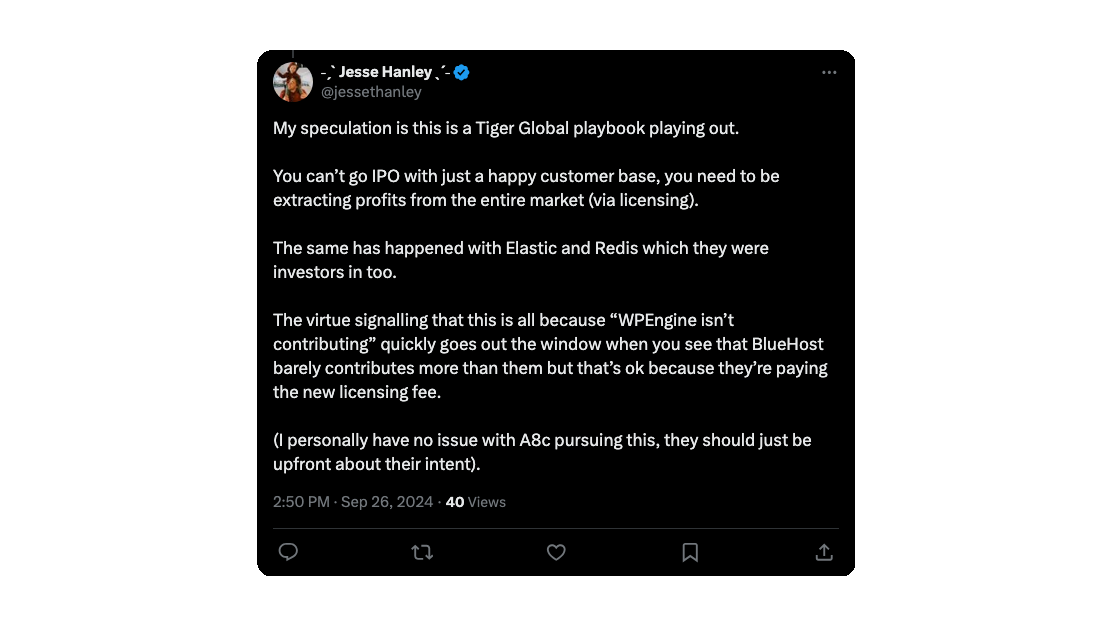

https://storage.cdn-luma.com/lit_lite_inference_v1.6-xl/d385ecee-7558-4620-8cf4-18d463233e4d/4a31f29a-950e-4104-8e54-db4607a60eb7_video03a30804cddc748b8ad0d022dfa06a504.mp4
https://storage.cdn-luma.com/lit_lite_inference_v1.6-xl/3a644152-e620-4bda-8f74-f1690f39b80f/75b595b0-e1ab-44ee-8895-d8ec0ddf823e_video0c6914559e0c84cf1914cdee55c1072f8.mp4


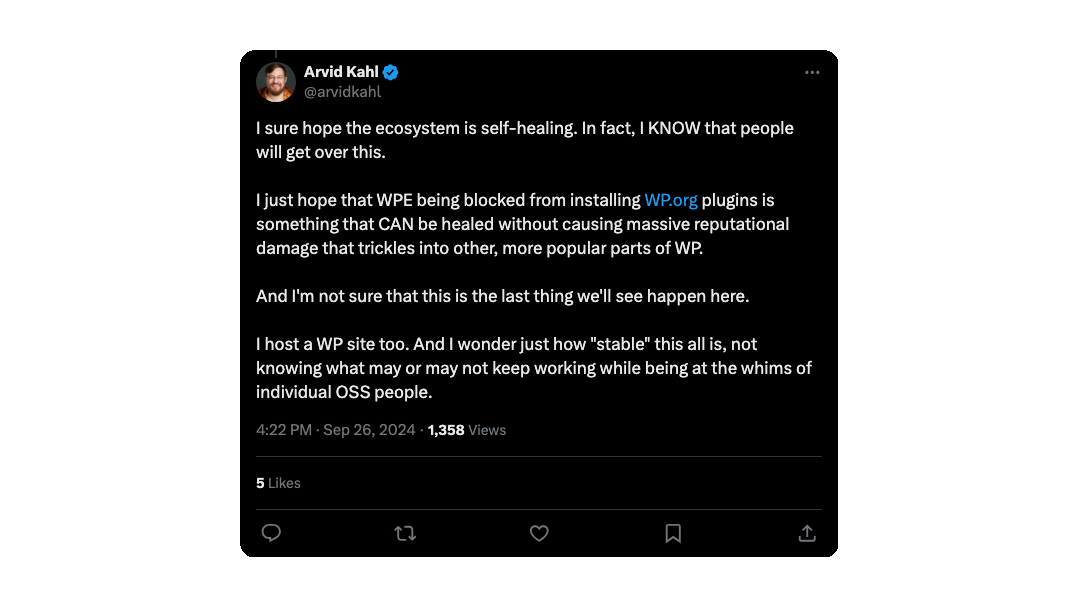

https://storage.cdn-luma.com/lit_lite_inference_v1.6-xl/a4f0bb36-f4ac-4da3-99e8-d8d7f4e19704/5dc4a9f8-2f0c-4bd1-bc42-3c532c2ddb9d_video0ba591e03883544eb82f6b99a45fc32ad.mp4
https://storage.cdn-luma.com/lit_lite_inference_v1.6-xl/4c59e3de-4700-49ea-8441-6b71f4289b0e/4683c35f-2aba-4d0f-ae41-8c4f2dcecfbb_video033b765e9050f48e2be9f9f27a1ad60d9.mp4
https://storage.cdn-luma.com/lit_lite_inference_v1.6-xl/9a15d4ec-48e9-40cf-ad52-0610dccb8d44/425f1d29-bd79-46b2-b9e3-d94254a852f9_video07e670c712317454e9529ade07738ed2a.mp4
https://storage.cdn-luma.com/lit_lite_inference_v1.6-xl/b95adda8-f829-482e-8d86-1dd303f7e912/9ca4c9ac-523d-461b-ae13-a3022d44cebd_video0919988de2fef43a09f910d9c7df744c4.mp4


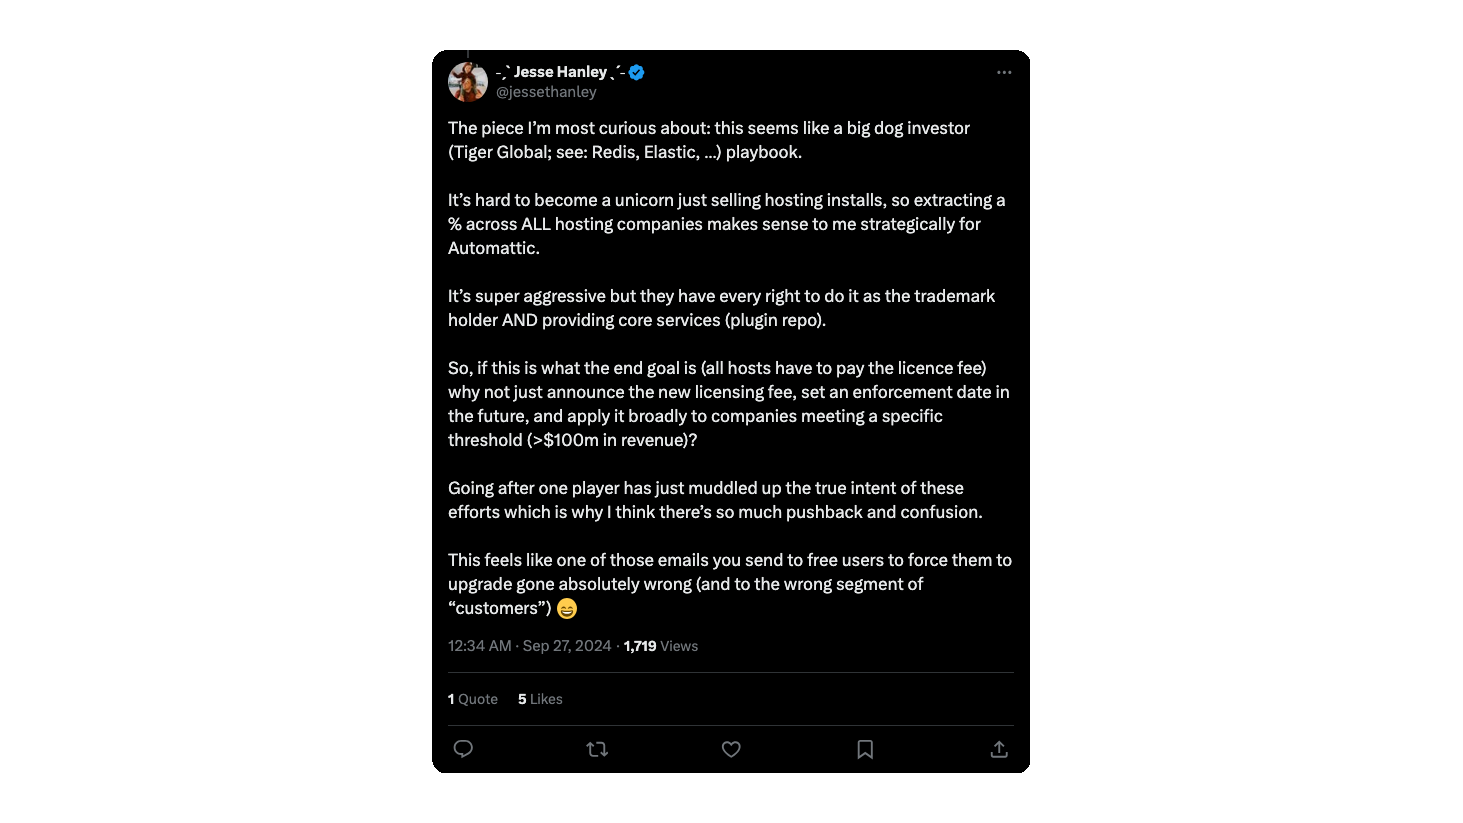

https://storage.cdn-luma.com/lit_lite_inference_v1.6-xl/afcaf670-c6d2-4f74-910a-625cff5dd0a0/9aa9b510-9511-4437-9e7d-9eac9f95fbad_video0741df6d11688487995e2374102644a16.mp4
https://storage.cdn-luma.com/lit_lite_inference_v1.6-xl/0ef16127-8b17-4fe4-9948-0e667332e66c/1899dc38-04e7-4a67-902d-083b339709e4_video01d3aa6f418e24dd9888079a957490741.mp4


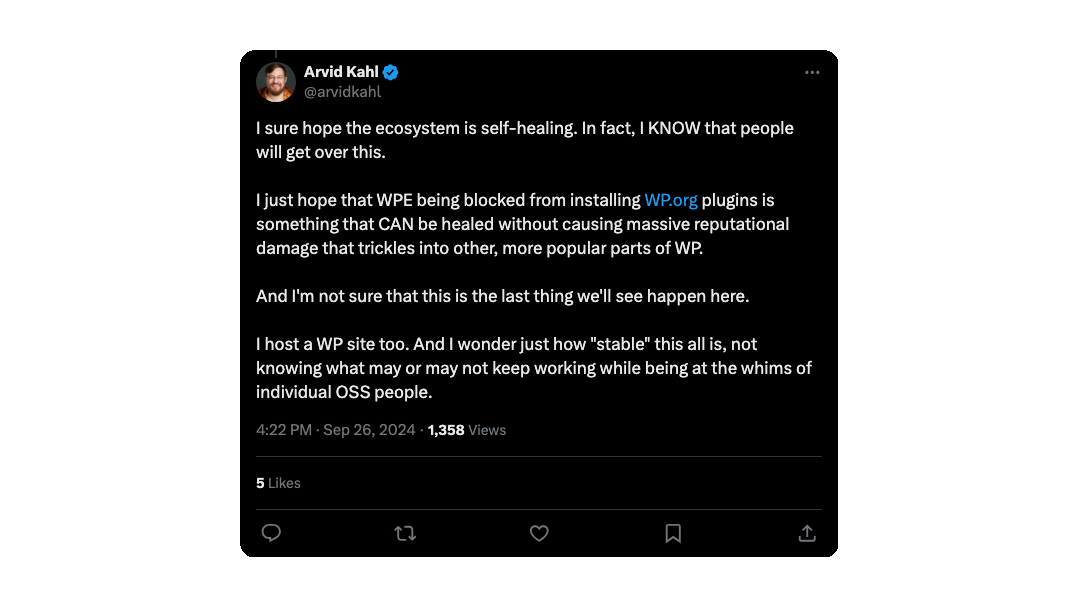

https://storage.cdn-luma.com/lit_lite_inference_v1.6-xl/23fbd373-b1c3-4558-930c-8808616e5da6/76a34ea4-5f2e-49b6-9768-52ee23670c10_video0c5683de6b56847c197910b49f3813522.mp4
https://storage.cdn-luma.com/lit_lite_inference_v1.6-xl/1193c028-eb98-408b-b431-7c548aa8a056/bfdc7196-e8a5-4682-80c1-cf8dbda3d1e5_video0d65c1b6bb63c401bbc3eeb49266d9a94.mp4


In [ ]:
from IPython.display import Image

for resource in combined_resources:
    if resource["type"] == "twitter_screenshot":
        display(Image(resource["file_path"]))
    elif resource["type"] == "stock_video" or resource["type"] == "meme":
        print(resource["result"].assets.video)

